In [10]:
import pandas as pd

df_partidos = pd.read_csv('partidos_cebollitas.csv')

# Filter only matches where Cebollitas FC plays
df_partidos = df_partidos[
    (df_partidos['equipo_local'] == 'Cebollitas FC') | 
    (df_partidos['equipo_visitante'] == 'Cebollitas FC')
]

# Create new columns for Cebollitas FC's performance
df_partidos['goles_cebollitas'] = df_partidos.apply(
    lambda x: x['goles_local'] if x['equipo_local'] == 'Cebollitas FC' else x['goles_visitante'], 
    axis=1
)

#Difencia de goles
df_partidos['diferencia_goles_cebollitas'] = df_partidos.apply(
    lambda x: x['goles_local'] - x['goles_visitante'] if x['equipo_local'] == 'Cebollitas FC' else x['goles_visitante'] - x['goles_local'], 
    axis=1
)

df_partidos['posesion_cebollitas'] = df_partidos.apply(
    lambda x: x['posesion_local (%)'] if x['equipo_local'] == 'Cebollitas FC' else x['posesion_visitante (%)'], 
    axis=1
)

df_partidos['tiros_cebollitas'] = df_partidos.apply(
    lambda x: x['tiros_arco_local'] if x['equipo_local'] == 'Cebollitas FC' else x['tiros_arco_visitante'], 
    axis=1
)

# Calculate ratio for Cebollitas FC
df_partidos['ratio_tiros_posesion_cebollitas'] = df_partidos['tiros_cebollitas'] / df_partidos['posesion_cebollitas']

df_partidos.head()

,fecha_partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local (%),posesion_visitante (%),tiros_arco_local,tiros_arco_visitante,estadio,goles_cebollitas,diferencia_goles_cebollitas,posesion_cebollitas,tiros_cebollitas,ratio_tiros_posesion_cebollitas
0,2023-01-01,Atlético Python,Cebollitas FC,2,0,54,46,12,6,Python Arena,0,-2,46,6,0.130435
2,2023-01-15,Cebollitas FC,Data United,1,0,55,45,10,7,Python Arena,1,1,55,10,0.181818
4,2023-01-29,Data United,Cebollitas FC,5,3,52,48,7,12,Estadio ML,3,-2,48,12,0.250000
5,2023-02-05,Data United,Cebollitas FC,3,3,60,40,8,11,Python Arena,3,0,40,11,0.275000
7,2023-02-19,Cebollitas FC,Real Pandas,1,2,56,44,5,5,Estadio ML,1,-1,56,5,0.089286


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

#Variables predictoras y objetivo
X = df_partidos[['posesion_local (%)', 'tiros_arco_local', 'ratio_tiros_posesion_cebollitas',]]

# Solo considerar los goles cuando Cebollitas FC juega como local
y = df_partidos[df_partidos['equipo_local'] == 'Cebollitas FC']['goles_local']

# Ajustar X para que coincida con los juegos donde Cebollitas FC es local
X = X[df_partidos['equipo_local'] == 'Cebollitas FC']

#Seleccionamos las 2 mejores características
selector = SelectKBest(score_func=f_regression, k=2)
selector.fit(X, y)

#Resultados ordenados por relevancia
scores = selector.scores_
variables = X.columns

resultados = pd.DataFrame({'Variable': variables, 'Score': scores}).sort_values(by='Score', ascending=False)
resultados

,Variable,Score
1,tiros_arco_local,2.183763
2,ratio_tiros_posesion_cebollitas,1.932511
0,posesion_local (%),0.081116


In [13]:
from sklearn.tree import DecisionTreeRegressor

#Entrenar el arbol de decision para medir la iomportancia de las variables
modelo_arbol = DecisionTreeRegressor(random_state=42)
modelo_arbol.fit(X, y)

#Importancia calculada por el arbol
importancia = modelo_arbol.feature_importances_

resultado_importancia = pd.DataFrame({'Variable': variables,
                                      'Importancia': importancia
                                      }).sort_values(by='Importancia', ascending=False)
resultado_importancia

,Variable,Importancia
0,posesion_local (%),0.469859
2,ratio_tiros_posesion_cebollitas,0.341213
1,tiros_arco_local,0.188929


C:\Users\sampa\AppData\Local\Temp\ipykernel_17352\2235361530.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados, x='Score', y='Variable', ax=ax[0], palette='viridis')
C:\Users\sampa\AppData\Local\Temp\ipykernel_17352\2235361530.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultado_importancia, x='Importancia', y='Variable', ax=ax[1], palette='magma')


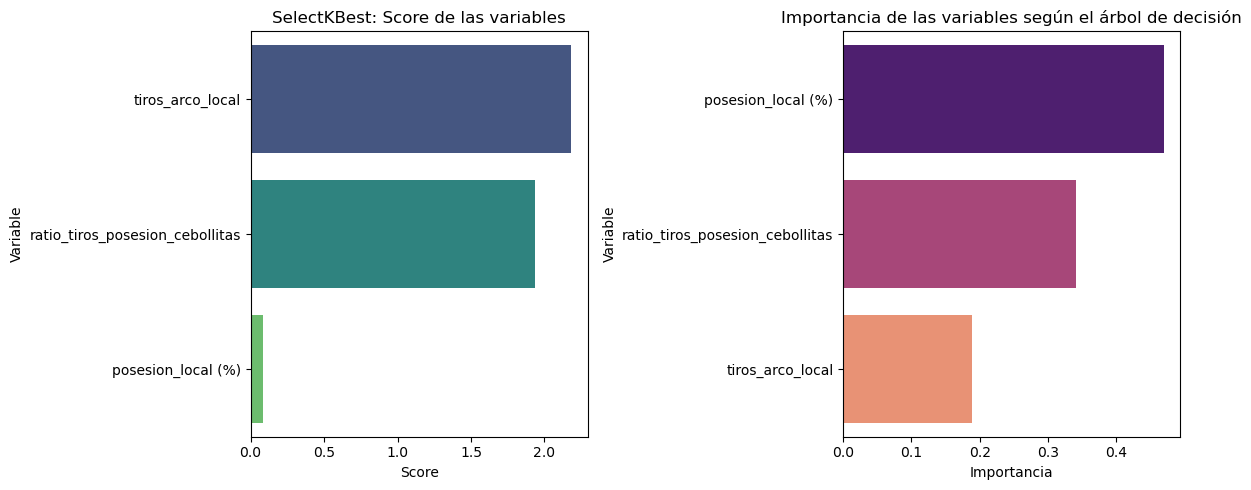

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#grafica selectKBest (analisis univariado)
sns.barplot(data=resultados, x='Score', y='Variable', ax=ax[0], palette='viridis')
ax[0].set_title('SelectKBest: Score de las variables')

#grafica importancia del arbol
sns.barplot(data=resultado_importancia, x='Importancia', y='Variable', ax=ax[1], palette='magma')
ax[1].set_title('Importancia de las variables según el árbol de decisión')

plt.tight_layout()
plt.show()